In [7]:
from cProfile import label
import os
from pyclbr import Function
from turtle import color
from xml.etree.ElementTree import PI
import math 
from sympy import apart
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
from dolfin import *
from matplotlib import pyplot
from ufl import nabla_div, nabla_grad,bessel_I,bessel_K
import numpy as np
import  sys
import mshr
from label_lines import *
import mpmath 

In [109]:
def besseli(n,f):
    if n==0:
        bes = bessel_I(n, f).evaluate(1,1,1,1)
    else:
        bes = mpmath.besseli(n,f)
    return bes
    return 
def besselk(n,f):
    if n==0:
        bes = bessel_K(n, f).evaluate(1,1,1,1)
    else:
        bes = mpmath.besselk(n,f)
    return bes

R_=300
H=10


# B_s=1E-11
# B_m=1E-10
B_f= 1E-9
Poro=0.4

K_m=500
nu=0.1#coeficiente de poisson  
#E=3*K_m*(1-2*nu)#(9*K_m*G_m)/(3*K_m+G_m)# #modulo elasticidad
B_m=(K_m)**(-1)
B_s=0
alpha=(1-B_s/B_m) #biotcoef
s_coef=(alpha-Poro)*B_s +Poro*B_f

theta =18.94#K(subd,18.94,20.61,23.27,20.53,21.84) #angulos friccion interna
C=15530#K(subd,15530,10350,18650,18400,14000) #cohesion

#E=B_m**(-1)*3*(1-2*nu)#modulo elasticidad 

mu =3*K_m*(1-2*nu)/(2*(1+nu))#coeficientes de Lame
print("relacion K/G= ",1/(B_m*mu))
lmbda =(3*K_m*nu)/(1+nu) #E*nu/((1+nu)*(1-2*nu))#coeficientes de Lame


K=1/10



cv_dot =(K*(1/B_m+mu/3))/(alpha**2+s_coef*(1/B_m+mu/3))
cv =(K*(1/B_m+4*mu/3))/(alpha**2+s_coef*(1/B_m+4*mu/3))

print('cv*=   ',cv_dot)
print('cv=   ',cv)
#material 
t=0 # tiempo inicial
Ti=0.15#tiempo total


dtdot=0.001
delta= dtdot/(cv/R_**2)
steps=int( 1/dtdot)
dt=Constant((delta))
#boundary conditions 
Caudal=10
flo=Constant((Caudal/(2*math.pi*H)))



snaps=50


Betta= 1#alpha/(alpha**2 + s_coef*(1/B_m+mu/3))
q_ = Caudal/(2*math.pi*H*K)
M=10
r = np.linspace(0.01, R_, snaps)

relacion K/G=  0.9166666666666667
cv*=    68.18179958678192
cv=    122.72721247936839


In [186]:

def pbar(r,s,f_const):
    ro=r/R_
    sigmma = (s * R_ ** 2) / cv_dot
    I_cero_ro = besseli(0, ro * (sigmma) ** (1 / 2))
    K_cero_ro = besselk(0, ro * (sigmma) ** (1 / 2))
    I_cero = besseli(0, (sigmma) ** (1 / 2))
    K_cero = besselk(0, (sigmma) ** (1 / 2))
    term_1 = (Betta * mu * f_const / q_) * (1 - I_cero_ro / I_cero)
    term_2 = (1 / sigmma) *( K_cero_ro-(K_cero / I_cero) * I_cero_ro)
    v_ray = (term_1 - term_2 )
    return v_ray


def f_coef(r,s,f_const):
    ro=r/R_
    sigmma = (s * R_ ** 2)/cv_dot
    part_1 = (2*alpha/sigmma**2)*(1-1/(besseli(0,np.sqrt(sigmma))))
    part_2 = 3/(B_m*mu) + alpha*Betta*(1-(2*besseli(1,np.sqrt(sigmma)))/(np.sqrt(sigmma)*besseli(0,np.sqrt(sigmma))))
    return (part_1/part_2)*q_/mu
def rad_displacement(r,s,f_const):
    ro = r/R_
    sigmma=(s * R_ ** 2) / cv_dot
    I_uno_ro = besseli(1, ro * (sigmma) ** (1 / 2))
    K_uno_ro = besselk(1, ro * (sigmma) ** (1 / 2))
    I_cero = besseli(0, (sigmma) ** (1 / 2))
    K_cero = besselk(0, (sigmma) ** (1 / 2))
    part_1_1 = ro/4- I_uno_ro/(2*sigmma**(1/2)*I_cero)
    part_1_2 = ro/4*(K_m/(mu)+4/3)
    part_1 = (alpha*Betta*part_1_1-part_1_2)
    part_2 = (K_uno_ro - 1/(ro*sigmma ** (1/2)) + (K_cero/I_cero)*I_uno_ro)
    n_ray = part_1*(mu*f_const/q_) + (alpha/(2 * sigmma * sigmma**(1/2)))*part_2
    return n_ray

def talbot(M, t,Fun,r=0,f_const=0):
    v=0
    for k in range(M ):
        if k == 0:
            delta =2 * M / 5
            gamma = np.exp(delta) / 2
        else:
            cot = 1 / np.tan(k * np.pi / M)
            delta = (2 * k * np.pi / 5) * (cot + 1j)
            gamma = (1 + 1j * (k * np.pi / M) *(1+ (cot) ** 2) - 1j* cot) * np.exp(delta)
        term_fun = delta / t
        termino = (gamma * Fun(r,term_fun,f_const))
        v += termino.real
    v_final=((2) / (5 * t)) * v
    return float(v_final)

def rad_displacementinv(s):
    sigmma=(s * R_ ** 2) / cv_dot
    I_uno_ro = mpmath.besseli(1, ro * (sigmma) ** (1 / 2))
    K_uno_ro = mpmath.besselk(1, ro * (sigmma) ** (1 / 2))
    I_cero = mpmath.besseli(0, (sigmma) ** (1 / 2))
    K_cero = mpmath.besselk(0, (sigmma) ** (1 / 2))
    part_1_1 = ro/4- I_uno_ro/(2*sigmma**(1/2)*I_cero)
    part_1_2 = ro/4*(1/(mu*B_m)+4/3)
    part_1 = (alpha*Betta*part_1_1-part_1_2)*(mu*f_const/q_)
    part_2 = (alpha/(2*sigmma**(3/2)))*(K_uno_ro - 1/(ro*sigmma ** (1/2)) + (K_cero/I_cero)*I_uno_ro)
    n_ray = part_1 + part_2
    return n_ray

    

def p_analitico(r,M,t):
    f_const = talbot(M, t, f_coef)
    for l in range(len(r)):   
        if l==0:
            v_final=np.array([[talbot(M, t, pbar,r=r[0],f_const=f_const)*R_**2/cv_dot,r[l]/R_]])
        else:
            v_final= np.append(v_final,np.array([[talbot(M, t, pbar,r=r[l],f_const=f_const)*R_**2/cv_dot,r[l]/R_]]),axis=0)
    return v_final

    return u_final
def u_analitico(r, M, t):
    f_const = talbot(M, t, f_coef)
    for l in range(len(r)):
        if l == 0:
            u_final= np.array([[-talbot(M, t, rad_displacement, r=r[0], f_const=f_const)*R_**2/cv_dot, r[l]/R_]])
        else:
            u_final = np.append(u_final,np.array([[-talbot(M, t, rad_displacement, r=r[l], f_const=f_const)*R_**2/cv_dot, r[l]/R_]]),axis=0)
    return u_final
def u_analiticoP(r, M, t):
    print("u analico init")
    f_const = talbot(M, t, f_coef)
    u_final=-talbot(M, t, rad_displacement, r=r, f_const=f_const)
    return -u_final*R_**2/cv_dot

(0, 0.25)

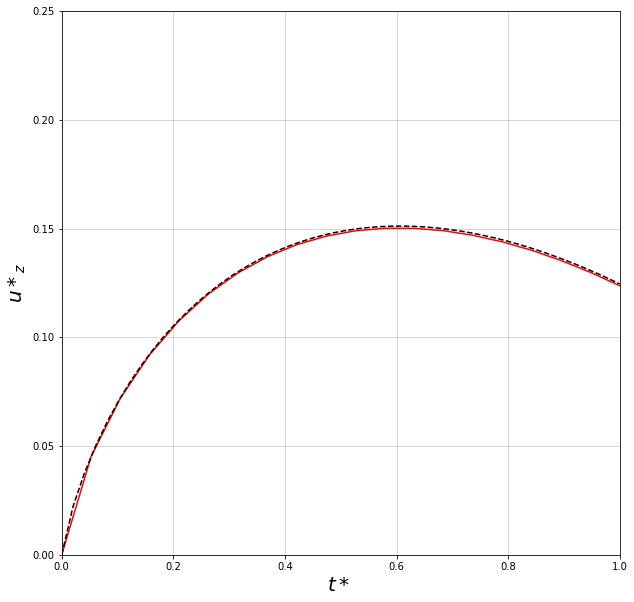

In [188]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Jun  1 14:26:23 2021
@author: SebastianG
"""



t=delta
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
L2=[]
uplot=[]

t=1/(cv_dot/R_**2)


# f_const = talbot(M, t, f_coef)
# for l in range(len(r)):
#     ro=r[l]/R_
#     print(ro)
#     if l == 0:
#         u_r= np.array([[-mpmath.invertlaplace(rad_displacementinv,t,method='talbot')*R_**2/cv_dot, r[0]/R_]])
#     else:
#         u_r = np.append(u_r,np.array([[-mpmath.invertlaplace(rad_displacementinv,t,method='talbot')*R_**2/cv_dot, r[l]/R_]]),axis=0)

plt.plot(u_r[:, 1], u_r[:, 0], "-", color='red')
u_a = u_analitico(r,M,t)
plt.plot(u_a[:, 1], u_a[:, 0], "--",color='black',label='Analítica')
plt.xlabel("$t*$ ",fontsize=20)
plt.ylabel("$u*_{z}$",fontsize=20)
plt.grid(True,color='k',which="both",alpha=0.3, linestyle='-', linewidth=0.5)
plt.xlim(0,1)
plt.ylim(0,0.25)

In [134]:
u_a


array([[  8.94817880e-05,   3.33333333e-05],
       [  2.20715139e-02,   2.04408163e-02],
       [  3.70375543e-02,   4.08482993e-02],
       [  4.93377584e-02,   6.12557823e-02],
       [  5.99073019e-02,   8.16632653e-02],
       [  6.91908968e-02,   1.02070748e-01],
       [  7.74507976e-02,   1.22478231e-01],
       [  8.48605294e-02,   1.42885714e-01],
       [  9.15436118e-02,   1.63293197e-01],
       [  9.75925561e-02,   1.83700680e-01],
       [  1.03079301e-01,   2.04108163e-01],
       [  1.08061431e-01,   2.24515646e-01],
       [  1.12586107e-01,   2.44923129e-01],
       [  1.16692689e-01,   2.65330612e-01],
       [  1.20414531e-01,   2.85738095e-01],
       [  1.23780277e-01,   3.06145578e-01],
       [  1.26814795e-01,   3.26553061e-01],
       [  1.29539888e-01,   3.46960544e-01],
       [  1.31974828e-01,   3.67368027e-01],
       [  1.34136776e-01,   3.87775510e-01],
       [  1.36041113e-01,   4.08182993e-01],
       [  1.37701702e-01,   4.28590476e-01],
       [  

In [18]:
uplot12

array([[ -2.00178556e-17,   3.33333333e-05],
       [ -3.67956638e-20,   1.69819209e-02],
       [ -1.84088197e-20,   3.39305085e-02],
       [ -1.22765835e-20,   5.08790960e-02],
       [ -9.20839049e-21,   6.78276836e-02],
       [ -7.36673373e-21,   8.47762712e-02],
       [ -6.13881221e-21,   1.01724859e-01],
       [ -5.26184980e-21,   1.18673446e-01],
       [ -4.60348845e-21,   1.35622034e-01],
       [ -4.09173516e-21,   1.52570621e-01],
       [ -3.68264101e-21,   1.69519209e-01],
       [ -3.34731990e-21,   1.86467797e-01],
       [ -3.06839283e-21,   2.03416384e-01],
       [ -2.83221882e-21,   2.20364972e-01],
       [ -2.62969254e-21,   2.37313559e-01],
       [ -2.45416411e-21,   2.54262147e-01],
       [ -2.30068964e-21,   2.71210734e-01],
       [ -2.16515807e-21,   2.88159322e-01],
       [ -2.04470769e-21,   3.05107910e-01],
       [ -1.93687094e-21,   3.22056497e-01],
       [ -1.83990703e-21,   3.39005085e-01],
       [ -1.75215323e-21,   3.55953672e-01],
       [ -